# Neal's funnel

This notebook introduces a toy distribution introduced by Radford Neal and is the $d+1$ dimensional,

$p(\boldsymbol{x},\nu) = \left[\prod_{i=1}^{d} \mathcal{N}(x_i|0,e^{\nu / 2})\right] \mathcal{N}(\nu|0,3),$

which has shown to cause problems for samplers owing to its "funnel" shaped geometry in the marginals $(x_i,\nu)$,

$p(x_i,\nu) = \mathcal{N}(x_i|0,e^{\nu / 2})\mathcal{N}(\nu|0,3),$

which we now plot.

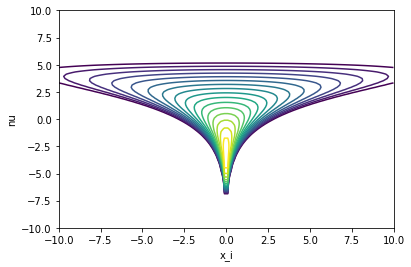

In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.NealsFunnelLogPDF()

# Plot marginal density
levels = np.linspace(-7, -1, 20)
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf.marginal_log_pdf(i, j) for i in x] for j in y]
plt.contour(X, Y, Z, levels = levels)
plt.xlabel('x_i')
plt.ylabel('nu')
plt.show()

We can also sample independently from this toy LogPDF, and add that to the visualisation:

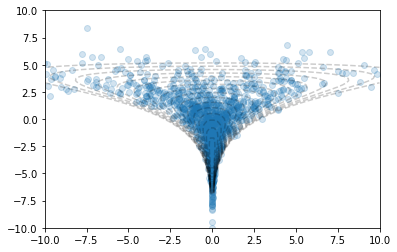

In [2]:
direct = log_pdf.sample(1500)

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(direct[:, 0], direct[:, 9], alpha=0.2)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

We now try to sample from the distribution with MCMC:

In [3]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform(-25, 25, size=(3, 10))
mcmc = pints.MCMCController(log_pdf, 3, x0, method=pints.HaarioBardenetACMC)

# Stop after 10000 iterations
mcmc.set_max_iterations(3000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Discard warm-up
chains = [chain[1000:] for chain in chains]

Running...
Done!


The adaptive covariance fails to get into the funnel region.

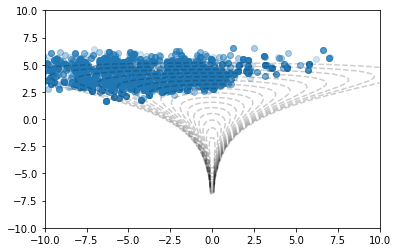

In [4]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(stacked[:, 0], stacked[:, 9], alpha=0.2)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

Now check how close the result is to the expected result, using the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence), and compare this to the result from sampling directly.

In [5]:
print(log_pdf.kl_divergence(stacked))
print(log_pdf.kl_divergence(direct))

1.66259443754
8.35418859013e-05


Hamiltonian Monte Carlo fares much better on this curved density.

In [28]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform(0, 10, size=(3, 10))
sigma0 = np.repeat(0.25, 10)
mcmc = pints.MCMCController(log_pdf, 3, x0, method=pints.HamiltonianMCMC, sigma0=sigma0)

# Stop after 10000 iterations
mcmc.set_max_iterations(500)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

stacked = np.vstack(chains)

Running...
Done!


Hamiltonian Monte Carlo does better than adaptive but still not great.

In [29]:
print(log_pdf.kl_divergence(stacked))
print(log_pdf.kl_divergence(direct))

0.451968021049
8.35418859013e-05


Visualising the path of one of the chains the sampler struggles to explore both the neck and the outside region efficiently.

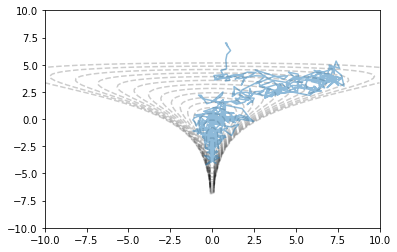

In [30]:
divergent_transitions = mcmc.samplers()[0].divergent_iterations()
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.plot(chains[2][:, 1], chains[2][:, 9], alpha=0.5)
plt.scatter(chains[0][divergent_transitions, 0], chains[0][divergent_transitions, 1], color='red')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()